# Trabajo practico V - Visión por computadora I

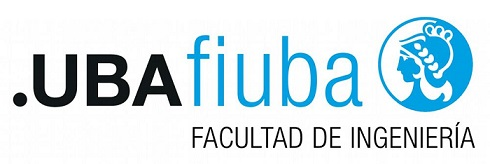

El objetivo de este trabajo práctico es aplicar los concpetos vistos en la clase 7 de la materia visión por computadora I de la Especialización en IA de la FIUBA

Primero cargaremos las libreriás necesarias para trabajar y luego se detalla cada parte y punto a analizar y trabajar, junto a las conclusiones obtenidas

## Cargamos las librerias necesarias

In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import os
from time import time

## Consignas:

* Implementar el detector de fondo naive usando la mediana como estimador El algoritmo debe recibir el parámetro N (cantidad de frames utilizados para la estimación) y el intervalo de tiempo para recalcular el fondo
* Se deben generar las mascaras de foreground y aplicarlas a los frames para segmentar los objetos en movimiento. Es deseable aplicar procesamiento morfologico a las mascaras.
* Comparar con alguno de los métodos vistos en la practica basados en mezcla de gaussianas (analizar tiempos de ejecución de cada algoritmo y nivel de ruido)

### Generamos la funcion de calculo por mediana

In [2]:
def crearrBckGroundMedian(capture,n_frames_est,cant_frames_procesados,soloParciales=False):
    
    lista_frames = []
    tot_frames = 0
    if cant_frames_procesados == 0:
        # Tomo por defecto los primeros frames, tengo la opcion de tomar al azar
        #tot_frames = capture.get(cv.CAP_PROP_FRAME_COUNT)   
        frames_para_calculo = np.arange(n_frames_est)
    else:
        #Tengo 2 alternativas de calculo segun la opcion soloParciales
        #Si soloParciales es verdadero uso solo la parte parcial del video que vengo procesando, del frame 0 al actual
        #Si soloParciales es falsa uso todos los frames del video sin importar el punto de ejecucion actual
        if soloParciales:
            tot_frames = cant_frames_procesados  
        else:
            tot_frames = capture.get(cv.CAP_PROP_FRAME_COUNT) 
        frames_para_calculo = (tot_frames*np.random.uniform(size=n_frames_est)).astype(int)
        
    #Obtengo los frames y los coloco en la lista
    for frame_id in frames_para_calculo:
        capture.set(cv.CAP_PROP_POS_FRAMES, frame_id)
        ret, frame = capture.read()
        lista_frames.append(frame)
    
    #Dejo video en el fram que estaba cuando ingreso
    capture.set(cv.CAP_PROP_POS_FRAMES, cant_frames_procesados)
    
    #Aplico la mediana al listado de frames
    mediana = np.median(lista_frames,axis=0).astype(dtype=np.uint8) 
    
    return mediana    

### Probamos nuestro filtro

In [3]:
filename = 'videos/personas.avi'
capture = cv.VideoCapture(filename)

In [4]:
n_frames_est = 20
filtro_mediana = crearrBckGroundMedian(capture,n_frames_est,0,True)

#### Lo mostramos en escala de grises

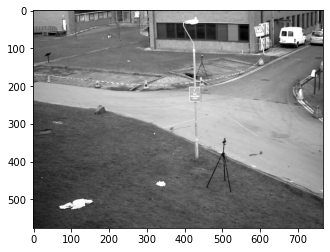

Shape del filtro:  (576, 768)


In [5]:
filtro_mediana_gray = cv.cvtColor(filtro_mediana, cv.COLOR_BGR2GRAY)
plt.imshow(filtro_mediana_gray,cmap="gray")
plt.show()   
print("Shape del filtro: ",filtro_mediana_gray.shape)

#### Lo mostramos en color

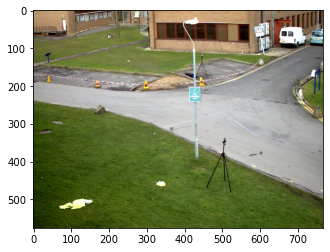

Shape del filtro:  (576, 768, 3)


In [6]:
plt.imshow(cv.cvtColor(filtro_mediana, cv.COLOR_BGR2RGB))
plt.show()  
print("Shape del filtro: ",filtro_mediana.shape)

### Generamos la funcion la sustracción de fondo

In [7]:
def sustraccion_fondo(video,metodo:str,n_frames_est=10,n_frames_recalc=100):
    if not video.isOpened:
        print('Falla al abrir el archivo: ' + filename)
        exit(0)
    
    backSubMOG2 = cv.createBackgroundSubtractorMOG2()
    backSubKNN = cv.createBackgroundSubtractorKNN(detectShadows = True)
    filt_med = crearrBckGroundMedian(video,n_frames_est,0,True)
    # Calculo ancho y alto para acomodar la imagen y los 3 filtrros en la pantalla
    h,w = filt_med.shape[:-1]
    #Achico el alto para poder ver todo junto
    h = int(0.75*h)
    
    #Variables para contar tiempo de ejecucino de los algoritmos
    tiempo_ejec_frame = 0
    tiempo_ejec_total = 0
    tiempo_ejec_totalMOG2 = 0
    tiempo_ejec_frameMOG2 = 0
    tiempo_ejec_totalKNN = 0
    tiempo_ejec_frameKNN = 0
    total_frames = video.get(cv.CAP_PROP_FRAME_COUNT)   
    
    # Ejecutamos la sustraccion
    #------------------------
    
    while True:
        # Leemos un frame
        ret, frame = video.read()
        
        if frame is None:
            break

        num_frame_actual = video.get(cv.CAP_PROP_POS_FRAMES)      
        #Recalculo el filtro en caso de llegar al numero de frame indicados
        if num_frame_actual % n_frames_recalc == 0 and metodo == 'MEDIAN':
            filt_med = crearrBckGroundMedian(video,n_frames_est,num_frame_actual,True) 
        
        #Calculo tiempo ejecucion para el analisis del frame con median
        start_time = time()
        # Aplicamos la sustracción al frame leído
        #----------------------------------------
        # Cada frame se utiliza tanto para calcular la máscara de primer plano como para actualizar el fondo.
        diff_img = cv.absdiff(frame, filt_med)
        #Paso a grayScale
        diff_img_gray = cv.cvtColor(diff_img, cv.COLOR_BGR2GRAY)
        
        #Opcion solo binarizacion con threshold a mano
        #thre, mascara = cv.threshold(diff_img_gray, 40, 255, cv.THRESH_BINARY)
        #Opcion con filtroa gaussiano y Otsu
        blur = cv.GaussianBlur(diff_img_gray,(5,5),0)
        thre,mascara = cv.threshold(blur,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
        #Aplico una apertura y cierre para filtrar ruido
        kernel = np.ones((3,3),np.uint8)
        # Aplicamos una serie de iteraciones de apertura
        masc_opening = cv.morphologyEx(mascara, cv.MORPH_OPEN, kernel, iterations = 2)
        fgMask = cv.morphologyEx(masc_opening, cv.MORPH_CLOSE, kernel, iterations = 2)
        tiempo_ejec_frame = time() - start_time
        tiempo_ejec_total += tiempo_ejec_frame
        #Calculo mascara de MOG2
        start_time = time()
        fgMaskMOG2 = backSubMOG2.apply(frame)
        tiempo_ejec_frameMOG2 = time() - start_time
        tiempo_ejec_totalMOG2 += tiempo_ejec_frameMOG2
        #Calculo mascara de KNN
        start_time = time()
        fgMaskKNN = backSubKNN.apply(frame)
        tiempo_ejec_frameKNN = time() - start_time
        tiempo_ejec_totalKNN += tiempo_ejec_frameKNN        
        
        # Escribimos sobre la imagen el número de frame procesado
        cv.rectangle(frame, (10, 2), (100,20), (255,255,255), -1)
        cv.putText(frame, str(num_frame_actual), (15, 15),
                   cv.FONT_HERSHEY_SIMPLEX, 0.5 , (0,0,0))

        #Escribimos sobre la mascara el frame procesado
        cv.rectangle(fgMask, (10, 2), (100,20), (255,255,255), -1)
        cv.putText(fgMask, str(num_frame_actual), (15, 15),
                   cv.FONT_HERSHEY_SIMPLEX, 0.5 , (0,0,0))  
        
        #Ajusto para mostrar las 4 imagenes juntas 
        cv.namedWindow('Video original')
        cv.moveWindow('Video original', 0,0)
        cv.imshow('Video original', frame)
        #
        cv.namedWindow('Máscara de mediana')
        cv.moveWindow('Máscara de mediana', 0,h)
        cv.imshow('Máscara de mediana', fgMask)
        #
        cv.namedWindow('Máscara de MOG2')
        cv.moveWindow('Máscara de MOG2', w,0)
        cv.imshow('Máscara de MOG2', fgMaskMOG2)
        #
        cv.namedWindow('Máscara de KNN')
        cv.moveWindow('Máscara de KNN', w,h)
        cv.imshow('Máscara de KNN', fgMaskKNN)

        # Corresmos hasta que termine o apriete escape
        keyboard = cv.waitKey(30)
        if keyboard == 'q' or keyboard == 27:
            break

    cv.destroyAllWindows()
    video.release()
    print(f"Tiempo ejecucion total para cálculo de máscara de mediana: {tiempo_ejec_total:.6f}")
    print(f"Tiempo promedio por frame para cálculo de máscara de mediana: {tiempo_ejec_total/total_frames:.6f}")
    print("\n")
    print(f"Tiempo ejecucion total para cálculo de máscara de MOG2: {tiempo_ejec_totalMOG2:.6f}")
    print(f"Tiempo promedio por frame para cálculo de máscara de MOG2: {tiempo_ejec_totalMOG2/total_frames:.6f}")
    print("\n")
    print(f"Tiempo ejecucion total para cálculo de máscara de KNN: {tiempo_ejec_totalKNN:.6f}")
    print(f"Tiempo promedio por frame para cálculo de máscara de KNN: {tiempo_ejec_totalKNN/total_frames:.6f}")    

### Cargamos el video y ejecutamos la funcion de sustracción

In [8]:
filename = 'videos/personas.avi'
video = cv.VideoCapture(filename)
sustraccion_fondo(video,10,100)

Tiempo ejecucion total para cálculo de máscara de mediana: 0.199601
Tiempo promedio por frame para cálculo de máscara de mediana: 0.000251


Tiempo ejecucion total para cálculo de máscara de MOG2: 1.807292
Tiempo promedio por frame para cálculo de máscara de MOG2: 0.002273


Tiempo ejecucion total para cálculo de máscara de KNN: 11.411021
Tiempo promedio por frame para cálculo de máscara de KNN: 0.014353


### Conclusiones

* Pudimos generar un filtrado de mediana de forma simple
* Pudimos aplicar ademas del filtrado de mediana un procesado morfológico para quitar ruido de la máscara
* Pudimos aplicar un filtrado con Otsu para mejorar la binarización 
* Pudimos correr las algoritmos de supresión de fondo de OpenCV visto en clase en paralelo con nuestro algoritmo de sustracción de mediana.
* Las ventajas obtenidas con nuestro algoritmo fueron:
    1- El ruido fue mucho menor y el filtrado fue mucho mejor. Sobretodo con el filtro inicial que tiene solo fondo
    2- El tiempo de ejecucion fue mucho menor que con los otros metodos